# Trabalho de implementação 2

### Autores

* Rafael Baldasso Audibert - 00287695
* Vinícius Marinho Maschio - 00231073

### Introdução

Esse é o relatório e a implementação do __Trabalho de Implementação 2__ para a disciplina de __Fundamentos de Visão Computacional - INF01030__, ministrada pelo professor __Cláudio Jung__

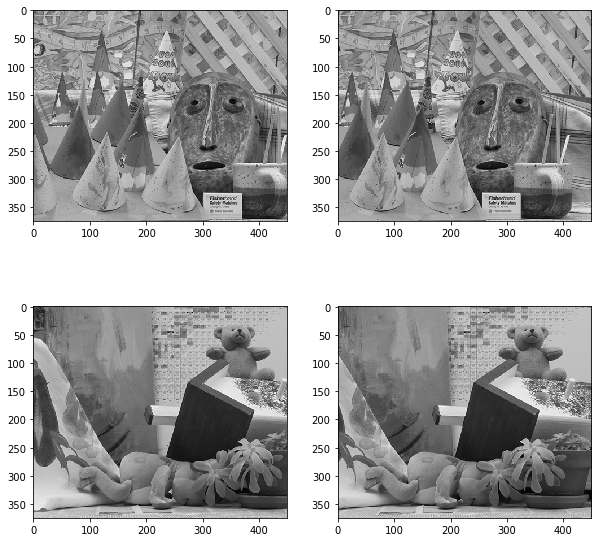

In [1]:
%matplotlib inline

# Imports
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

# Basic function to display B&W image
def display_image(img, title='', figsize=(5, 5)):
    fig, axarr = plt.subplots(1, figsize=figsize)
    axarr.imshow(img, cmap="gray")
    axarr.set_title(title)
    
# Load images
cones2 = cv2.cvtColor(cv2.imread('data/cones/im2.png'), cv2.COLOR_BGR2GRAY)
cones6 = cv2.cvtColor(cv2.imread('data/cones/im6.png'), cv2.COLOR_BGR2GRAY)
teddy2 = cv2.cvtColor(cv2.imread('data/teddy/im2.png'), cv2.COLOR_BGR2GRAY)
teddy6 = cv2.cvtColor(cv2.imread('data/teddy/im6.png'), cv2.COLOR_BGR2GRAY)

# We want in [left, right] order
cones = [cones2, cones6]
teddy = [teddy2, teddy6]
image_datasets = [cones, teddy]

# Plotting original images   
fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
for idx_dataset, dataset in enumerate(image_datasets):
    for idx_image, image in enumerate(dataset):
        axarr[idx_dataset, idx_image].imshow(image, interpolation="nearest", cmap=plt.cm.gray)
        
# DP with every squared value, to compute SSD disparity faster
SQUARED_DP = {x: x ** 2 for x in range(-256, 256)}

## Questão 1

> Considere um par de imagens estéreo, já retificadas. Considerando uma das imagens como
referência, o objetivo é calcular a disparidade $d$ para cada pixel $(x, y)$ da imagem, definida como
aquela para qual um custo $C_0(x, y, d)$ é mínimo. Teste os seguintes critérios de custo para o cálculo
da disparidade:

### Item a

> soma dos quadrados das distâncias ($SSD$, ou sum of squared distances) Euclideanas (usando
espaço de cores RGB) em uma vizinhança quadrada ao redor do pixel em análise de tamanho
$N×N$. Varie o tamanho da vizinhança e avalie o resultado. Em particular, teste a vizinhança
$1 × 1$, ou seja, considerando apenas o pixel em análise

### Item b

>  soma de alguma medida de distância robusta aplicada aos vetores de cor RGB. Sugere-se usar
$ρ(d) = d^2 / (d^2 + \epsilon^2)$, onde $\epsilon$ é um parâmetro que você deve ajustar. Assim como no item (a),
varie o tamanho da vizinhança e avalie os resultados em seu relatório.

#### Implementação

In [2]:
def disparity(image_left, image_right, disparity_func, kernel_size=5, max_offset=100):
    height, width = image_left.shape
    
    # Depth (or disparity) map
    disparity_map = np.zeros((height, width))
    
    # In practice this makes our kernel size to always be NxN if N is odd, else (N+1)x(N+1)
    kernel_offset = kernel_size // 2    
    offset_adjust = 255 / max_offset  # this is used to map depth map output to 0-255 range
      
    for y in tqdm(range(kernel_offset, height - max(kernel_offset, 1)), desc="Image line"):      
        for x in range(kernel_offset, width - max(kernel_offset, 1)):
            best_offset = 0
            prev_disp = float("Inf")
            
            for offset in range(max_offset):               
                disp = 0
                
                # v and u are the x,y of our local window search, used to ensure a good 
                # match- going by the squared differences of two pixels alone is insufficient, 
                # we want to go by the squared differences of the neighbouring pixels too
                # We have this max(kernel_offset, 1) to be able to have a 1x1 kernel
                for v in range(-kernel_offset, kernel_offset + 1):
                    for u in range(-kernel_offset, kernel_offset + 1):
                        # iteratively sum the sum of squared differences value for this block
                        # left[] and right[] are arrays of uint8, so converting them to int saves
                        # potential overflow, and executes a lot faster
                        disp += disparity_func(int(image_left[y+v, x+u]), int(image_right[y+v, (x+u) - offset]))      
                
                # if this value is smaller than the previous ssd at this block
                # then it's theoretically a closer match. Store this value against
                # this block..
                if disp < prev_disp:
                    prev_disp = disp
                    best_offset = offset
                            
            # set depth output for this x,y location to the best match
            disparity_map[y, x] = best_offset * offset_adjust
    
    return disparity_map

def ssd_disparity(image_left, image_right, kernel_size=5, max_offset=100):
    return disparity(image_left, image_right, lambda x, y: SQUARED_DP[x - y], kernel_size, max_offset)

def robust_ssd_disparity(image_left, image_right, e=0, kernel_size=5, max_offset=100):
    e_squared = e ** 2
    return disparity(image_left, image_right, lambda x, y: SQUARED_DP[x - y] / (SQUARED_DP[x - y] + e_squared), kernel_size, max_offset)

### Resposta
Acima temos a implementação do cálculo de disparidade, usando tanto SSD (_sum of squared distances_) quanto um SSD mais robusto, utilizando um parâmetro $\epsilon$, testado em vários casos de parâmetros. O algoritmo mais robusto possui resultados piores que o SSD padrão caso $\epsilon$ seja pequeno, resultando resultados parecido em torno de $\epsilon = 50$. Abaixo temos os resultados obtidos aplicando diferentes tamanhos de núcleo, e diferentes offsets máximos.

Uma coisa importante a se notar, é que as imagens de exemplo `teddy` e `cones` foram tiradas com uma grande disparidade por padrão (por exemplo, repare nas figuras plotadas anteriormente, como os objetos próximos a câmera possuem uma diferença de cerca de 50 pixeis), portanto, utilizamos um offset máximo (representado no código pelo parâmetro `max_offset`) bem grande, para poder levar isso em consideração. Isso traz problemas ao tentarmos analisar o fundo das imagens, não detectando tão bem que ele se mexeu "pouco" já que fazemos um espaço de busca muito grande.

**OBS:** Nas análises das imagens abaixo, quanto mais escuro for um pixel, mais longe ele está da câmera.

Interessante notar que com um kernel pequeno, conseguimos o que parece ser um bom detector de bordas para os objetos próximos a câmera, encontrando pixeis muitos parecidos de maneira fácil.

Na imagem `cones` podemos notar que, de certa forma, conseguimos notar que os triângulos tem volume, e profundidade, embora o resultado seja extremamente ruidoso. Também, conseguimos notar que as treliças à direita no fundo da imagem, tiveram seus padrões detectados, embora ele ache que elas estão mais próximas da câmera do que deveriam estar, provavelmente porque como nosso offset é muito grande, ele acaba encontrando a próxima treliça a direita, retornando possivelmente um melhor resultado por causa da iluminação.

Na imagem `teddy` somos capaz de detectar corretamente que temos uma parede no fundo, com uma coisa perto da parede mas um pouco mais a frente, no canto esquerdo. Também, detectamos que o ursinho teddy está bem a frente. É um pouco confuso o resultado nas plantas e no livro, com o algoritmo achando que algumas coisas estão bem ao fundo, embora isso não faça muito sentido.

De forma geral, podemos dizer que os melhores resultados obtidos, em ambas as images foram com um núcleo maior (diminuindo os ruídos) e um offset maior (já que as fotos tem uma boa distância de pixel entre as mesmas). Podemos afirmar que o melhor resultado para as 2 fotos, entre os hiperparametros utilizados, foi com kernel de tamanho 7 e offset 70. O problema, porém, é o custo de executar isso, levando 8 minutos para computar essa imagem de disparidade em um processador i5 7th generation 3.2GHz.

Kernel size:   0%|          | 0/3 [00:00<?, ?it/s]

Max Offset:   0%|          | 0/4 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Max Offset:   0%|          | 0/4 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Max Offset:   0%|          | 0/4 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Kernel size:   0%|          | 0/3 [00:00<?, ?it/s]

Max Offset:   0%|          | 0/4 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Max Offset:   0%|          | 0/4 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Max Offset:   0%|          | 0/4 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

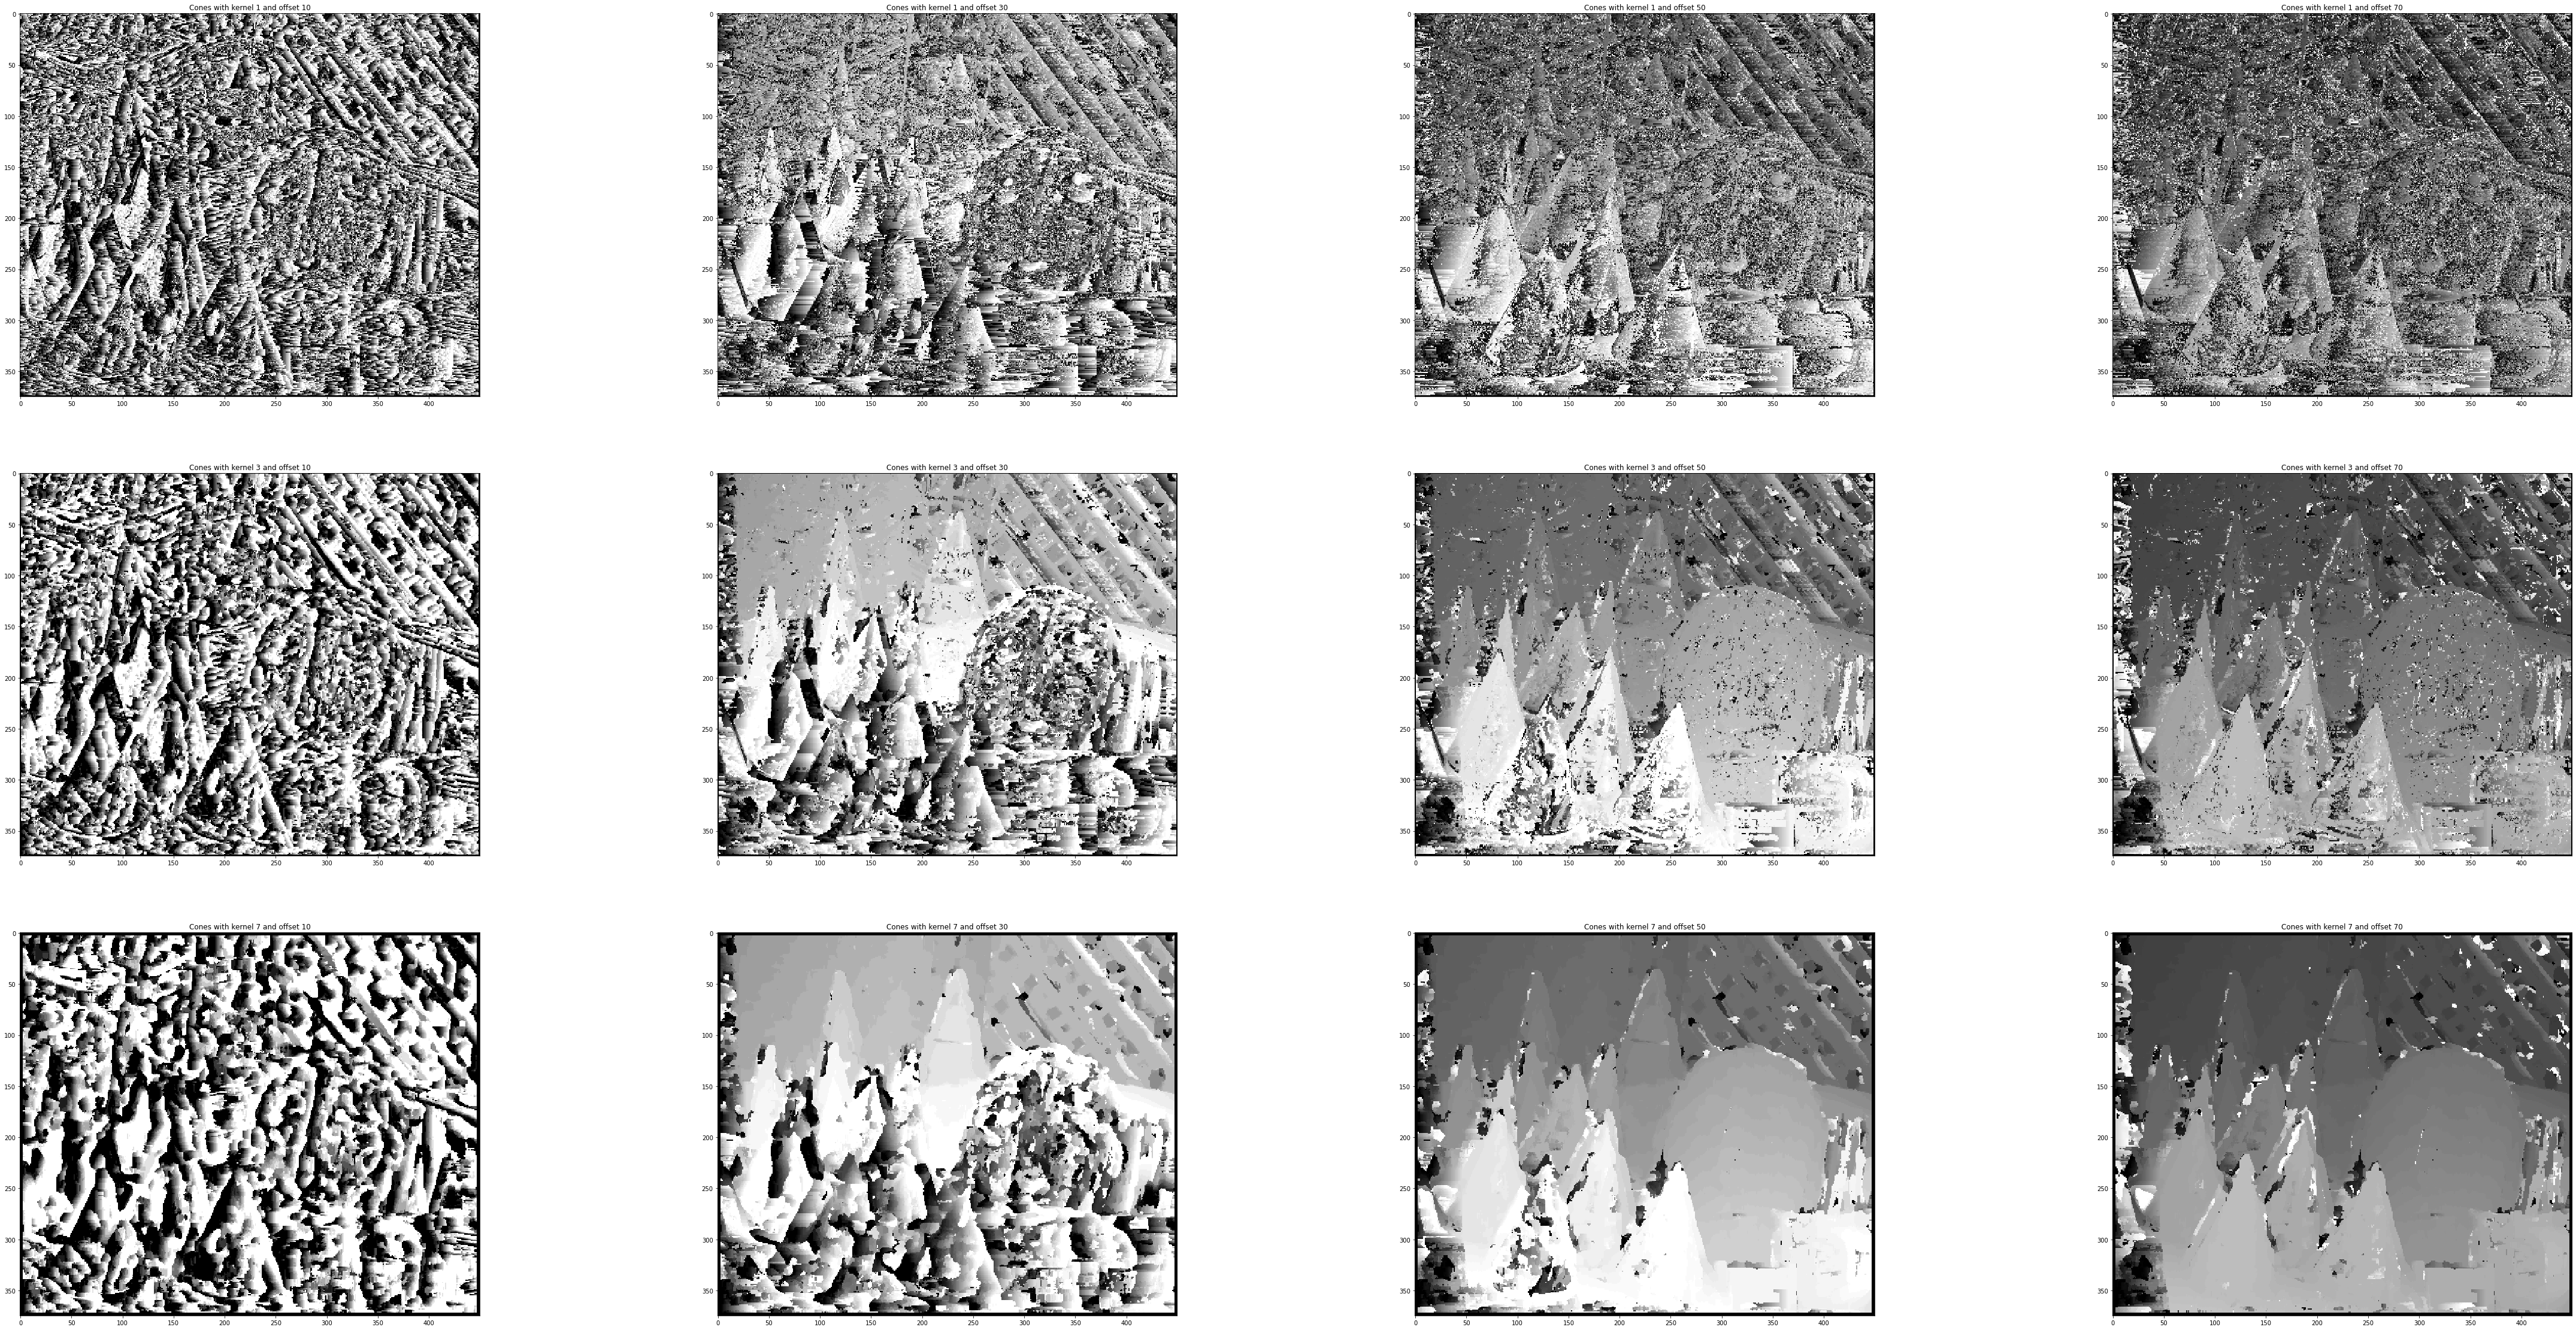

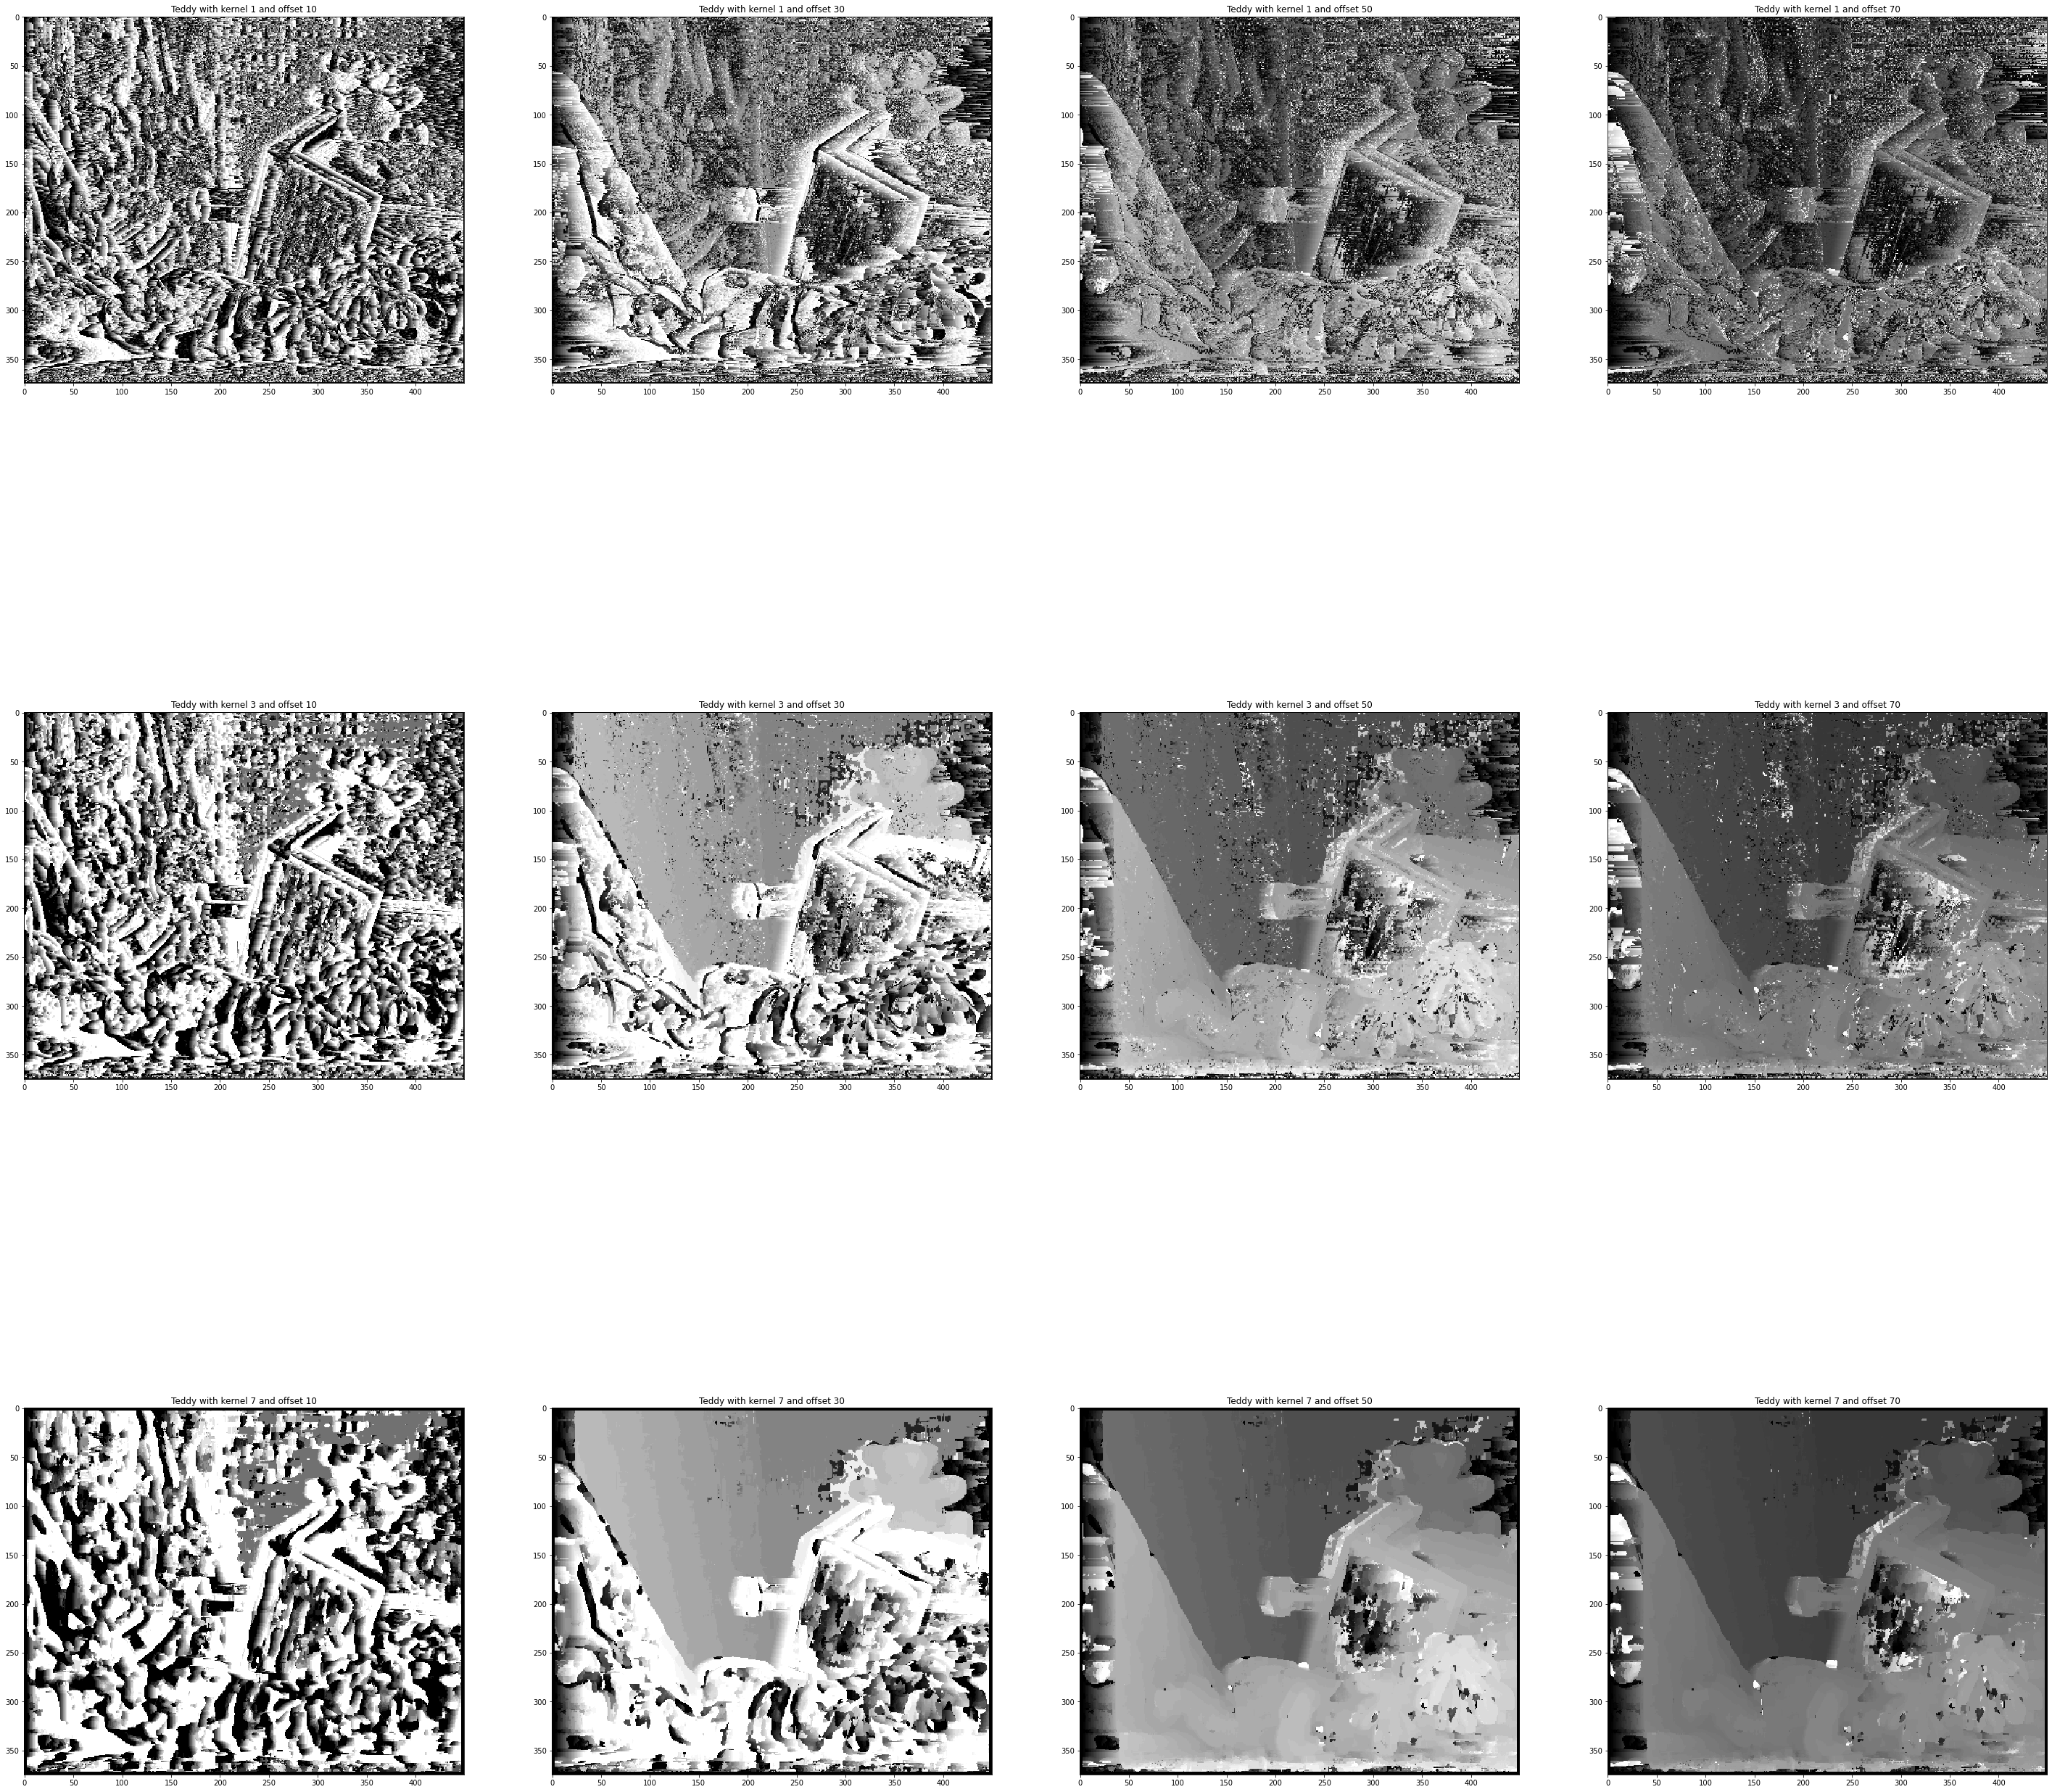

In [7]:
kernel_sizes = [1, 3, 7]
max_offsets = [10, 30, 50, 70]

fig, axarr = plt.subplots(len(kernel_sizes), len(max_offsets), figsize=(80, 40))
cones_disp_image = [[0 for _ in range(len(max_offsets))] for _ in range(len(kernel_sizes))]
for idx_kernel, kernel_size in tqdm(list(enumerate(kernel_sizes)), desc="Kernel size"):
    for idx_offset, max_offset in tqdm(list(enumerate(max_offsets)), desc="Max Offset"):
        cones_disp_image[idx_kernel][idx_offset] = ssd_disparity(*cones, kernel_size, max_offset)
        axarr[idx_kernel, idx_offset].imshow(cones_disp_image[idx_kernel][idx_offset], interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_kernel, idx_offset].set_title(f"Cones with kernel {kernel_size} and offset {max_offset}")

fig, axarr = plt.subplots(len(kernel_sizes), len(max_offsets), figsize=(50, 50))
teddy_disp_image = [[0 for _ in range(len(max_offsets))] for _ in range(len(kernel_sizes))]
for idx_kernel, kernel_size in tqdm(list(enumerate(kernel_sizes)), desc="Kernel size"):
    for idx_offset, max_offset in tqdm(list(enumerate(max_offsets)), desc="Max Offset"):
        teddy_disp_image[idx_kernel][idx_offset] = ssd_disparity(*teddy, kernel_size, max_offset)
        axarr[idx_kernel, idx_offset].imshow(teddy_disp_image[idx_kernel][idx_offset], interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_kernel, idx_offset].set_title(f"Teddy with kernel {kernel_size} and offset {max_offset}")

Kernel size:   0%|          | 0/3 [00:00<?, ?it/s]

Epsilon:   0%|          | 0/3 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Epsilon:   0%|          | 0/3 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Epsilon:   0%|          | 0/3 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Kernel Size:   0%|          | 0/3 [00:00<?, ?it/s]

Epsilon:   0%|          | 0/3 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Image line:   0%|          | 0/374 [00:00<?, ?it/s]

Epsilon:   0%|          | 0/3 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Image line:   0%|          | 0/373 [00:00<?, ?it/s]

Epsilon:   0%|          | 0/3 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

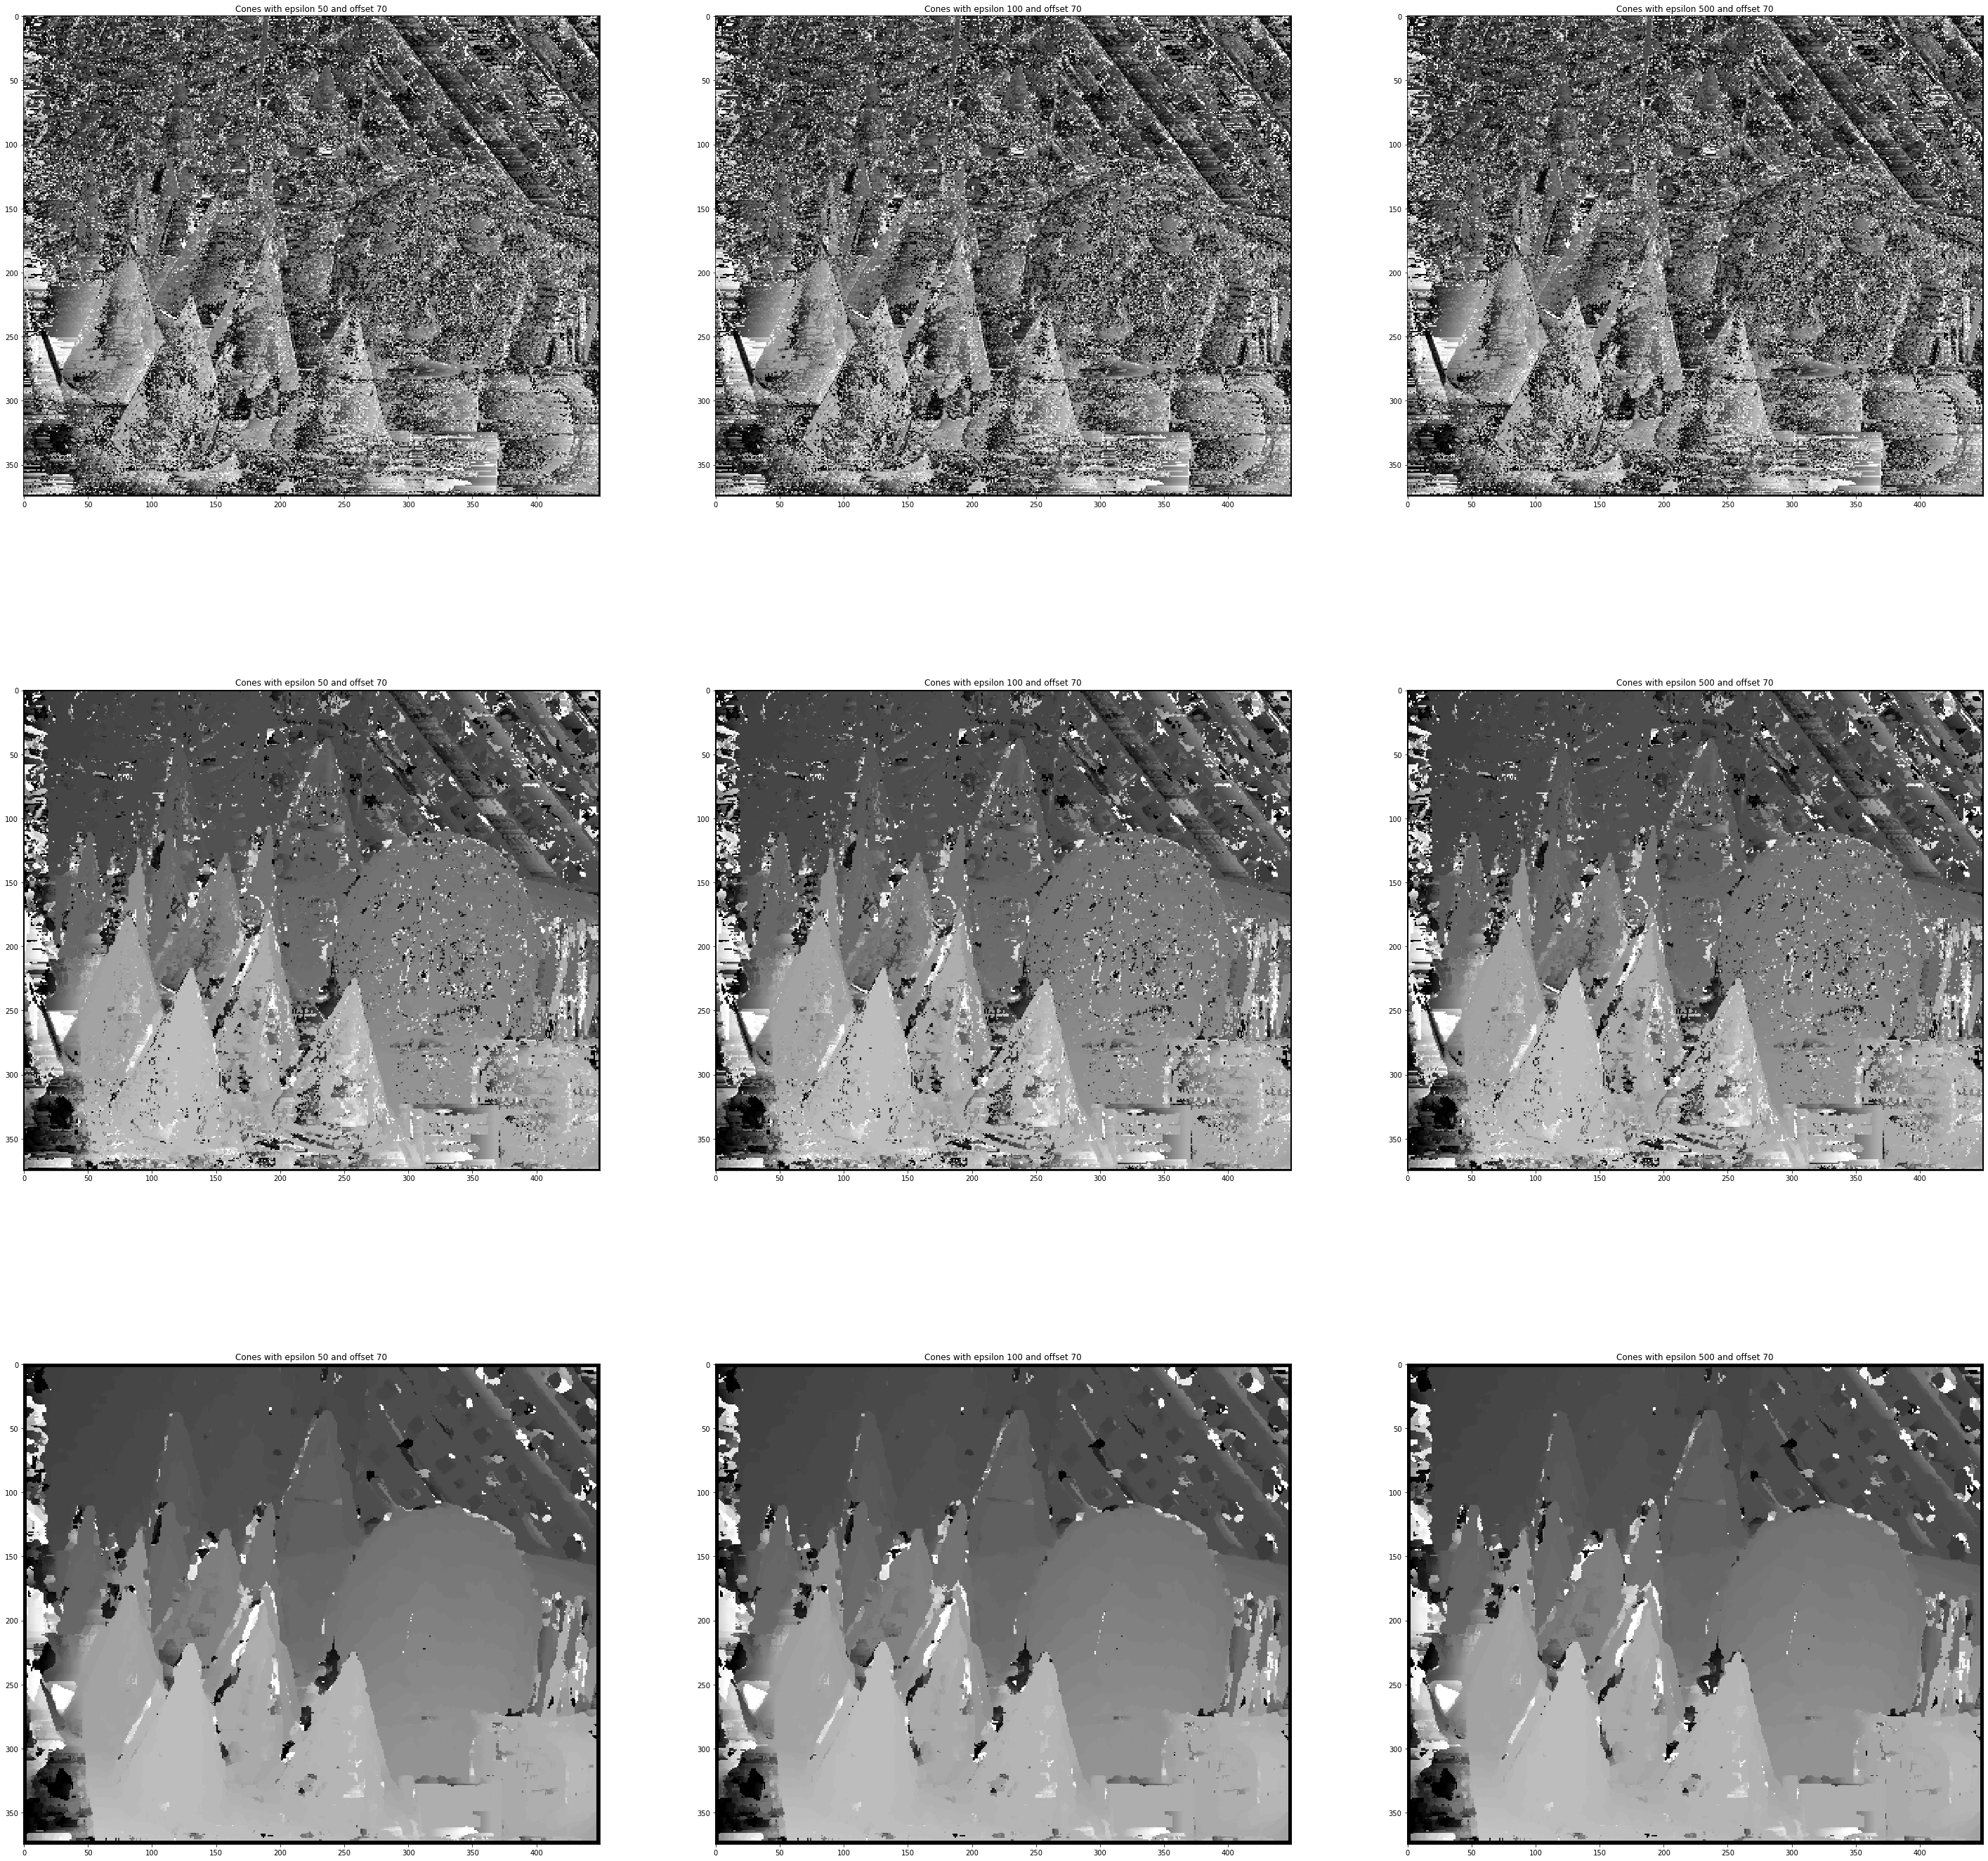

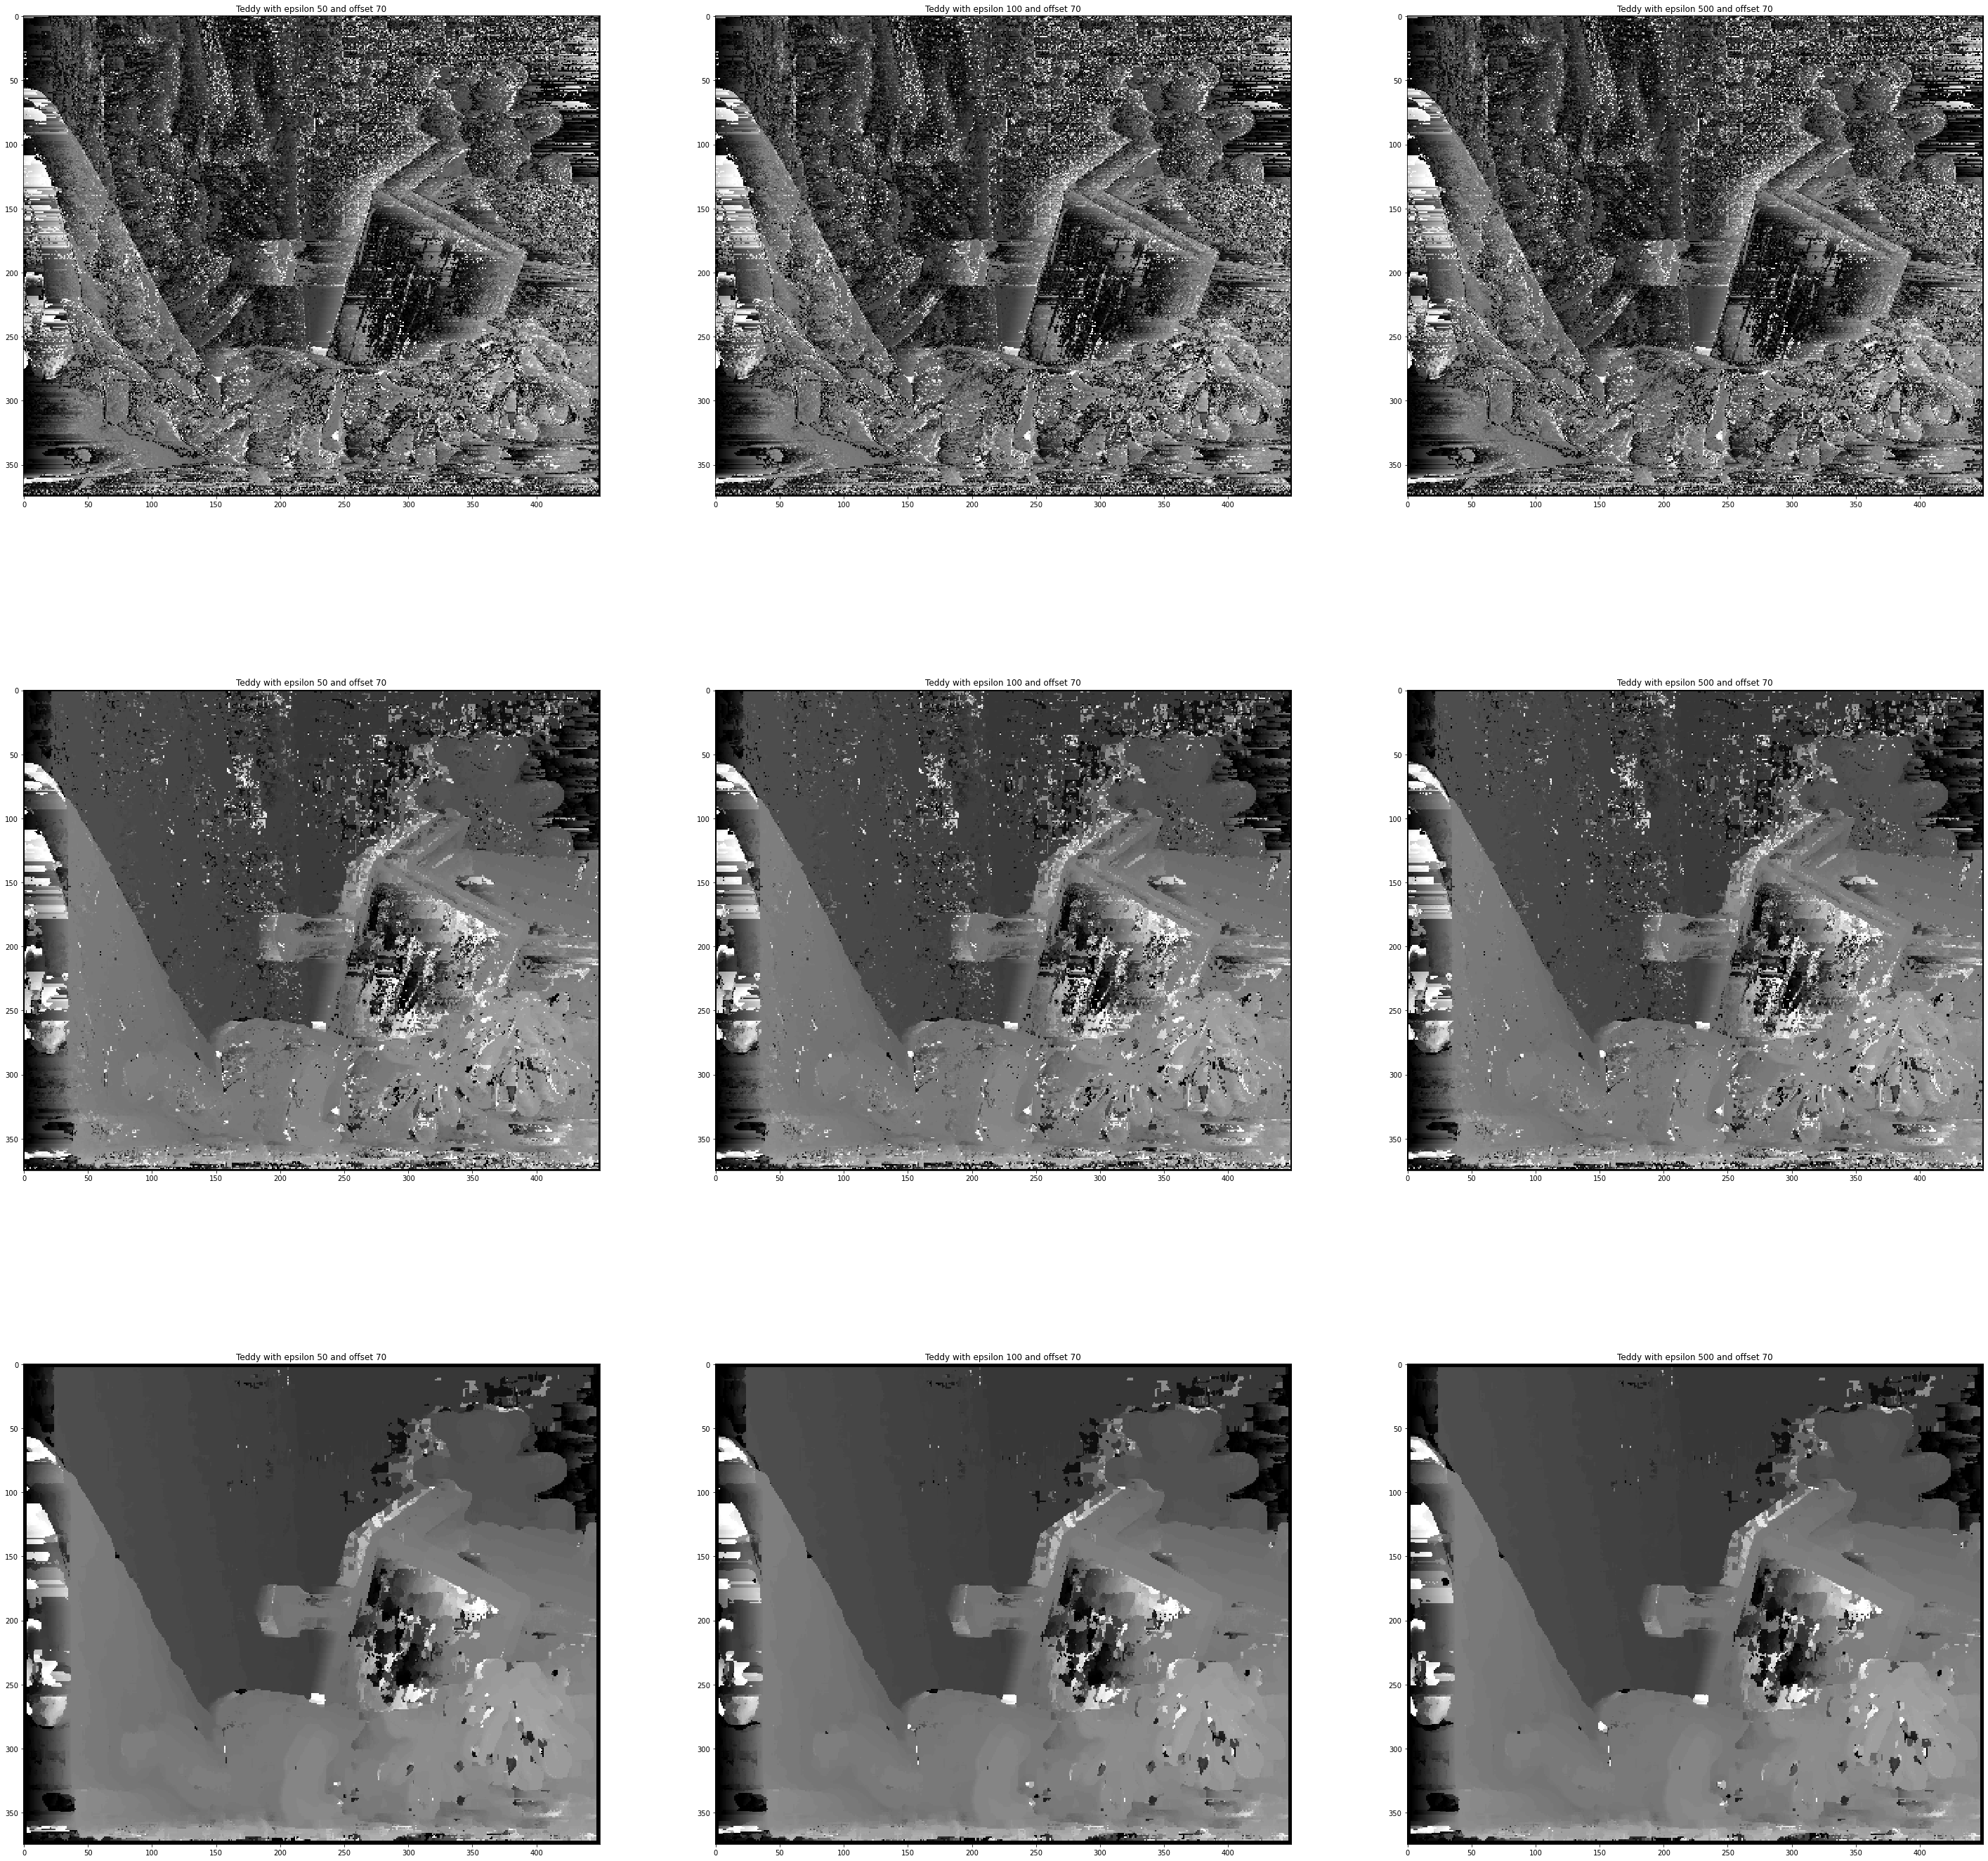

In [13]:
kernel_sizes = [1, 3, 7]
epsilons = [50, 100, 500]
max_offset = 70

fig, axarr = plt.subplots(len(kernel_sizes), len(epsilons), figsize=(50, 50))
cones_disp_image_better = [[0 for _ in range(len(epsilons))] for _ in range(len(kernel_sizes))]
for idx_kernel, kernel_size in tqdm(list(enumerate(kernel_sizes)), desc="Kernel size"):
    for idx_epsilon, epsilon in tqdm(list(enumerate(epsilons)), desc="Epsilon"):
        cones_disp_image_better[idx_kernel][idx_epsilon] = robust_ssd_disparity(*cones, epsilon, kernel_size, max_offset)
        axarr[idx_kernel, idx_epsilon].imshow(cones_disp_image_better[idx_kernel][idx_epsilon], interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_kernel, idx_epsilon].set_title(f"Cones with epsilon {epsilon} and offset {max_offset}")

fig, axarr = plt.subplots(len(kernel_sizes), len(epsilons), figsize=(50, 50))
teddy_disp_image_better = [[0 for _ in range(len(epsilons))] for _ in range(len(kernel_sizes))]
for idx_kernel, kernel_size in tqdm(list(enumerate(kernel_sizes)), desc="Kernel Size"):
    for idx_epsilon, epsilon in tqdm(list(enumerate(epsilons)), desc="Epsilon"):
        teddy_disp_image_better[idx_kernel][idx_epsilon] = robust_ssd_disparity(*teddy, epsilon, kernel_size, max_offset)
        axarr[idx_kernel, idx_epsilon].imshow(teddy_disp_image_better[idx_kernel][idx_epsilon], interpolation="nearest", cmap=plt.cm.gray)
        axarr[idx_kernel, idx_epsilon].set_title(f"Teddy with epsilon {epsilon} and offset {max_offset}")

Para analisar os dados utilizando um SSD mais robusto, fixamos nosso offset em 70, já que foi o que obteve melhor resultado com o SSD normal.

Variamos nosso $\epsilon$ entre os valores $50$, $100$ e $500$, pois com valores menores que isso obtíamos péssimos resultados.

POdemos visualizar abaixo uma comparação entre utilizarmos somente o SSD ou utilizar o epsilon robusto, porém, não somos capazes de detectar uma melhora considerável, sendo que o tempo para cálculo dos ambos é o mesmo (minimamente mais lento para o robusto, por ter que calcular $\epsilon^2$, ao invés de poder acessar nossa tabela $DP$).

Image line:   0%|          | 0/369 [00:00<?, ?it/s]

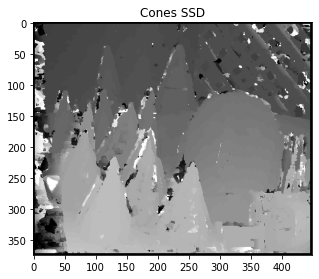

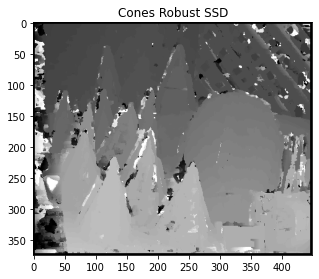

In [14]:
cones_ssd = ssd_disparity(*cones, 7, 70)
display_image(cones_ssd, title="Cones SSD")
display_image(cones_disp_image_better[2][2], title="Cones Robust SSD")